# 📓 Notebook - Teori & Praktik Bab 13: Loading & Preprocessing Data

Pelatihan Deep Learning membutuhkan data dalam jumlah besar. Seringkali, data tidak muat di RAM. Oleh karena itu, diperlukan *pipeline* data yang efisien yang dapat memuat, memproses, dan mengirimkan data ke GPU/TPU tanpa menghambat proses pelatihan.

Topik pembahasan meliputi:
1.  **Data API (`tf.data`)**: Membangun *pipeline* data yang kompleks (shuffling, batching, mapping).
2.  **TFRecord Format**: Format biner efisien untuk penyimpanan data besar.
3.  **Keras Preprocessing Layers**: Melakukan standarisasi, one-hot encoding, dan embedding langsung di dalam model.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow Version: {tf.__version__}")

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow Version: 2.20.0


## 1. The Data API (`tf.data`)

### Teori
Objek `tf.data.Dataset` merepresentasikan urutan elemen data. Data dapat berasal dari memori (array) atau dari penyimpanan disk (file gambar/teks).

Transformasi utama dalam pipeline:
* `from_tensor_slices`: Membuat dataset dari array/tensor.
* `map`: Mengaplikasikan fungsi transformasi ke setiap elemen.
* `shuffle`: Mengacak urutan data (penting untuk Stochastic Gradient Descent).
* `batch`: Mengelompokkan data menjadi tumpukan kecil.
* `prefetch`: Menyiapkan batch berikutnya saat GPU sedang memproses batch saat ini (paralelisasi CPU & GPU).

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)

print("Isi Dataset Awal:")
for item in dataset:
    print(item.numpy(), end=" ")

dataset_processed = (
    dataset
    .repeat(2)
    .shuffle(buffer_size=5, seed=42)
    .map(lambda x: x * 2)
    .batch(4)
    .prefetch(1)
)

print("\n\nIsi Dataset Setelah Proses (Batched & Shuffled):")
for batch in dataset_processed:
    print(batch.numpy())

Isi Dataset Awal:
0 1 2 3 4 5 6 7 8 9 

Isi Dataset Setelah Proses (Batched & Shuffled):
[ 0  2 12 10]
[14  6 18 16]
[4 2 0 8]
[12  8 14  4]
[ 6 16 18 10]


In [3]:
dataset_inspect = tf.data.Dataset.from_tensor_slices({
    'features': tf.random.uniform((100, 5)),
    'labels': tf.random.uniform((100,), maxval=10, dtype=tf.int32)
})

print("Element spec:")
print(dataset_inspect.element_spec)

print("\nSample data (3 examples):")
for i, element in enumerate(dataset_inspect.take(3)):
    print(f"Example {i+1}:")
    print(f"  Features shape: {element['features'].shape}")
    print(f"  Label: {element['labels'].numpy()}")

Element spec:
{'features': TensorSpec(shape=(5,), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(), dtype=tf.int32, name=None)}

Sample data (3 examples):
Example 1:
  Features shape: (5,)
  Label: 8
Example 2:
  Features shape: (5,)
  Label: 3
Example 3:
  Features shape: (5,)
  Label: 9


### 1.2 Advanced tf.data Features

Untuk dataset besar dan production, ada beberapa optimasi penting:
- **`cache()`**: Menyimpan dataset di memori setelah load pertama
- **`from_file_pattern`**: Membaca multiple files sekaligus
- **`interleave`**: Parallel file reading untuk performa tinggi

In [4]:
dataset_no_cache = tf.data.Dataset.range(1000)
dataset_no_cache = dataset_no_cache.map(lambda x: x ** 2)

dataset_with_cache = tf.data.Dataset.range(1000)
dataset_with_cache = dataset_with_cache.map(lambda x: x ** 2).cache()

import time

start = time.time()
for _ in range(3):
    for _ in dataset_no_cache.batch(100):
        pass
time_no_cache = time.time() - start

start = time.time()
for _ in range(3):
    for _ in dataset_with_cache.batch(100):
        pass
time_with_cache = time.time() - start

print(f"Time without cache: {time_no_cache:.4f}s")
print(f"Time with cache:    {time_with_cache:.4f}s")
print(f"Speedup: {time_no_cache/time_with_cache:.2f}x")

Time without cache: 0.0575s
Time with cache:    0.0474s
Speedup: 1.21x


## 2. Format TFRecord

### Teori
Format **TFRecord** adalah format biner sederhana yang menyimpan urutan record biner (protokol buffer). Format ini lebih cepat dibaca daripada file teks (CSV/JSON) dan ideal untuk dataset besar yang di-*stream* melalui jaringan.

Biasanya, data disimpan dalam bentuk pesan `tf.train.Example` yang berisi fitur-fitur (Features).

In [5]:

filename = "my_data.tfrecord"

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

with tf.io.TFRecordWriter(filename) as writer:
    for i in range(3):
        example = tf.train.Example(features=tf.train.Features(feature={
            'id': _int64_feature(i),
            'name': _bytes_feature(f"Data-{i}".encode('utf-8')),
            'value': _float_feature(i * 1.5),
            'category': _int64_feature(i % 2)
        }))
        writer.write(example.SerializeToString())

print(f"File {filename} berhasil dibuat dengan tf.train.Example format")

def parse_tfrecord(example_proto):
    """Parse serialized Example."""
    feature_description = {
        'id': tf.io.FixedLenFeature([], tf.int64),
        'name': tf.io.FixedLenFeature([], tf.string),
        'value': tf.io.FixedLenFeature([], tf.float32),
        'category': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

dataset_tfrecord = tf.data.TFRecordDataset([filename])
dataset_parsed = dataset_tfrecord.map(parse_tfrecord)

print("\nMembaca isi TFRecord:")
for record in dataset_parsed:
    print(f"ID: {record['id'].numpy()}, "
          f"Name: {record['name'].numpy().decode('utf-8')}, "
          f"Value: {record['value'].numpy():.1f}, "
          f"Category: {record['category'].numpy()}")

File my_data.tfrecord berhasil dibuat dengan tf.train.Example format

Membaca isi TFRecord:
ID: 0, Name: Data-0, Value: 0.0, Category: 0
ID: 1, Name: Data-1, Value: 1.5, Category: 1
ID: 2, Name: Data-2, Value: 3.0, Category: 0


## 3. Keras Preprocessing Layers

### Teori
Dahulu, *preprocessing* (normalisasi, encoding) dilakukan menggunakan Scikit-Learn atau Pandas sebelum data masuk ke model. Sekarang, Keras menyediakan layer khusus untuk melakukan ini **di dalam** model.

Keuntungan:
1.  Model menjadi portabel (preprocessing ikut tersimpan saat model diekspor).
2.  Preprocessing dapat berjalan di GPU.

Layer utama:
* `Normalization`: Standarisasi fitur numerik (Z-score).
* `StringLookup` & `IntegerLookup`: Mengubah kategori menjadi indeks integer.
* `CategoryEncoding`: Mengubah integer menjadi *One-Hot Vector*.

### 3.1 Normalisasi Fitur Numerik

In [6]:
X_train_num = np.array([[20.], [30.], [40.], [50.]])

norm_layer = keras.layers.Normalization()

norm_layer.adapt(X_train_num)

X_new = np.array([[20.], [50.]])
print("Mean yang dipelajari:", norm_layer.mean.numpy())
print("Variance yang dipelajari:", norm_layer.variance.numpy())
print("\nHasil Normalisasi (Z-Score):\n", norm_layer(X_new).numpy())

Mean yang dipelajari: [[35.]]
Variance yang dipelajari: [[125.]]

Hasil Normalisasi (Z-Score):
 [[-1.3416408]
 [ 1.3416408]]


### 3.2 Encoding Fitur Kategorikal (String)

Untuk data teks kategori (misal: "Kucing", "Anjing"), langkahnya adalah:
1.  `StringLookup`: Ubah String $\rightarrow$ Integer Index.
2.  `CategoryEncoding`: Ubah Integer $\rightarrow$ One-Hot Vector (jika kategori sedikit) ATAU `Embedding` layer (jika kategori banyak).

In [7]:
X_train_cat = np.array([["Kucing"], ["Anjing"], ["Kucing"], ["Burung"]])

lookup_layer = keras.layers.StringLookup(output_mode="int")
lookup_layer.adapt(X_train_cat)

print("Vocabulary:", lookup_layer.get_vocabulary())
indices = lookup_layer([["Anjing"], ["Burung"], ["Ular"]]) # Ular = OOV (Out of Vocabulary)
print("Indices:", indices.numpy())

one_hot_layer = keras.layers.CategoryEncoding(num_tokens=lookup_layer.vocabulary_size())
print("One-Hot Output:\n", one_hot_layer(indices).numpy())

Vocabulary: ['[UNK]', np.str_('Kucing'), np.str_('Burung'), np.str_('Anjing')]
Indices: [[3]
 [2]
 [0]]
One-Hot Output:
 [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


### 3.3 Embedding Layer

Jika jumlah kategori sangat banyak (ribuan), *One-Hot Encoding* menjadi tidak efisien. Digunakan **Embedding Layer** yang memetakan setiap indeks kategori ke vektor padat (*dense vector*) berdimensi rendah yang dapat dilatih.

In [8]:

input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)

x = lookup_layer(input_layer)

x = keras.layers.Embedding(input_dim=lookup_layer.vocabulary_size(), output_dim=2)(x)

model_embed = keras.models.Model(inputs=input_layer, outputs=x)

input_data = tf.constant([["Kucing"], ["Anjing"]])
print("Embedding untuk 'Kucing' dan 'Anjing':")
print(model_embed.predict(input_data))

Embedding untuk 'Kucing' dan 'Anjing':
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[[[-0.0209975  -0.01412219]]

 [[ 0.00259609  0.02879662]]]


### 3.4 Text Preprocessing dengan TextVectorization

Untuk data teks (review, komentar, artikel), `TextVectorization` mengubah teks mentah menjadi sekuens integer atau bag-of-words.

In [9]:
texts = [
    "Produk ini sangat bagus dan berkualitas",
    "Sangat buruk tidak sesuai ekspektasi",
    "Bagus banget recommended",
    "Kualitas produk sangat memuaskan"
]

text_vectorizer_seq = keras.layers.TextVectorization(
    max_tokens=50,
    output_mode='int',
    output_sequence_length=10
)

text_vectorizer_seq.adapt(texts)

print("Vocabulary (top 10):")
print(text_vectorizer_seq.get_vocabulary()[:10])

print("\nInteger Sequences:")
sequences = text_vectorizer_seq(texts)
print(sequences.numpy())

text_vectorizer_bow = keras.layers.TextVectorization(
    max_tokens=50,
    output_mode='multi_hot'
)

text_vectorizer_bow.adapt(texts)

print("\nBag-of-Words (Multi-Hot):")
bow_output = text_vectorizer_bow(texts[:2])
print(bow_output.numpy())

Vocabulary (top 10):
['', '[UNK]', np.str_('sangat'), np.str_('produk'), np.str_('bagus'), np.str_('tidak'), np.str_('sesuai'), np.str_('recommended'), np.str_('memuaskan'), np.str_('kualitas')]

Integer Sequences:
[[ 3 10  2  4 12 14  0  0  0  0]
 [ 2 13  5  6 11  0  0  0  0  0]
 [ 4 15  7  0  0  0  0  0  0  0]
 [ 9  3  2  8  0  0  0  0  0  0]]

Bag-of-Words (Multi-Hot):
[[0 1 1 1 0 0 0 0 0 1 0 1 0 1 0]
 [0 1 0 0 1 1 0 0 0 0 1 0 1 0 0]]


### 3.5 Image Preprocessing Layers

Untuk data gambar, Keras menyediakan layer preprocessing seperti `Rescaling`, `Resizing`, dan augmentation layers.

In [10]:
dummy_images = np.random.randint(0, 256, size=(5, 28, 28, 1), dtype=np.uint8)

print("Original image range:", dummy_images.min(), "-", dummy_images.max())

rescaling_layer = keras.layers.Rescaling(scale=1./255)
normalized_images = rescaling_layer(dummy_images)

print("After rescaling:", normalized_images.numpy().min(), "-", normalized_images.numpy().max())

resizing_layer = keras.layers.Resizing(height=32, width=32)
resized_images = resizing_layer(dummy_images)

print("After resizing:", resized_images.shape)

augmentation_model = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

print("\nData Augmentation applied:")
augmented = augmentation_model(dummy_images, training=True)
print("Shape tetap:", augmented.shape)

Original image range: 0 - 255
After rescaling: 0.0 - 1.0
After resizing: (5, 32, 32, 1)

Data Augmentation applied:
Shape tetap: (5, 28, 28, 1)


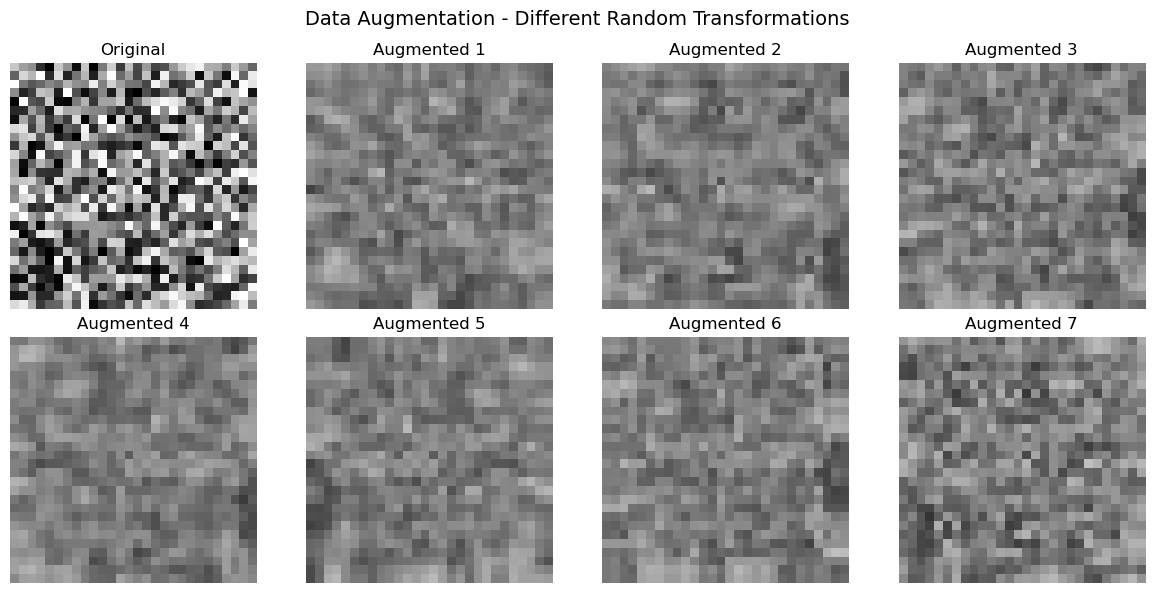

In [11]:
single_image = np.random.randint(50, 200, size=(28, 28, 1), dtype=np.uint8)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes[0, 0].imshow(single_image.squeeze(), cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

for i in range(7):
    row = (i + 1) // 4
    col = (i + 1) % 4
    augmented = augmentation_model(single_image[np.newaxis, ...], training=True)
    axes[row, col].imshow(augmented[0].numpy().squeeze(), cmap='gray', vmin=0, vmax=255)
    axes[row, col].set_title(f'Augmented {i+1}')
    axes[row, col].axis('off')

plt.suptitle('Data Augmentation - Different Random Transformations', fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
ages = np.array([[18.], [25.], [30.], [45.], [60.], [75.]])

discretization_layer = keras.layers.Discretization(bin_boundaries=[25., 50.])

discretized = discretization_layer(ages)
print("Discretization (Age -> Bin Index):")
for age, bin_idx in zip(ages.flatten(), discretized.numpy().flatten()):
    print(f"  Age {age:.0f} -> Bin {bin_idx}")

user_ids = tf.constant([["user_12345"], ["user_99999"], ["user_54321"]])

hashing_layer = keras.layers.Hashing(num_bins=10)

hashed = hashing_layer(user_ids)
print("\nHashing (High-Cardinality -> Fixed Bins):")
for user, hash_val in zip(user_ids.numpy(), hashed.numpy()):
    print(f"  {user[0].decode('utf-8')} -> Bucket {hash_val[0]}")

Discretization (Age -> Bin Index):
  Age 18 -> Bin 0
  Age 25 -> Bin 1
  Age 30 -> Bin 1
  Age 45 -> Bin 1
  Age 60 -> Bin 2
  Age 75 -> Bin 2

Hashing (High-Cardinality -> Fixed Bins):
  user_12345 -> Bucket 6
  user_99999 -> Bucket 2
  user_54321 -> Bucket 8


---
## 🚀 BAGIAN II: END-TO-END PIPELINE
---

## 4. Complete Pipeline: California Housing

Contoh lengkap: Data → Preprocessing → Model → Training dengan dataset real.

In [13]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_full, y_full = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Dataset Shapes:")
print(f"  Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")
print(f"\nFeatures: {housing.feature_names}")

Dataset Shapes:
  Train: (13209, 8), Valid: (3303, 8), Test: (4128, 8)

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [14]:
def create_dataset(X, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train, y_train, shuffle=True)
valid_dataset = create_dataset(X_valid, y_valid, shuffle=False)
test_dataset = create_dataset(X_test, y_test, shuffle=False)

print("tf.data pipelines created!")

tf.data pipelines created!


In [15]:
model_housing = keras.Sequential([
    keras.layers.Normalization(input_shape=[8]),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(1)
])

norm_layer_housing = model_housing.layers[0]
norm_layer_housing.adapt(X_train)

model_housing.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("Model Architecture:")
model_housing.summary()

Model Architecture:


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,706 (10.57 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 17 (72.00 B)

In [16]:
history = model_housing.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    verbose=0
)

print("✅ Training complete!")

✅ Training complete!



Test Results:
  MAE: $0.39k (Mean Absolute Error)
  MSE: 0.32


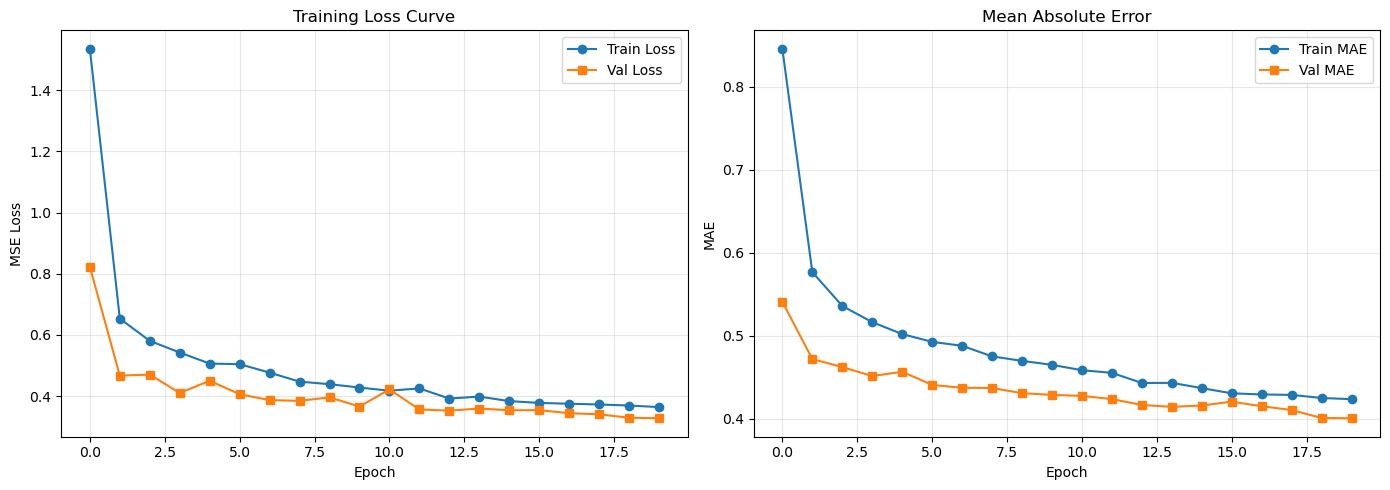


Final Model Performance: MAE = $0.39k


In [17]:
test_loss, test_mae = model_housing.evaluate(test_dataset, verbose=0)
print(f"\nTest Results:")
print(f"  MAE: ${test_mae:.2f}k (Mean Absolute Error)")
print(f"  MSE: {test_loss:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Loss Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot MAE
axes[1].plot(history.history['mae'], label='Train MAE', marker='o')
axes[1].plot(history.history['val_mae'], label='Val MAE', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Model Performance: MAE = ${test_mae:.2f}k")

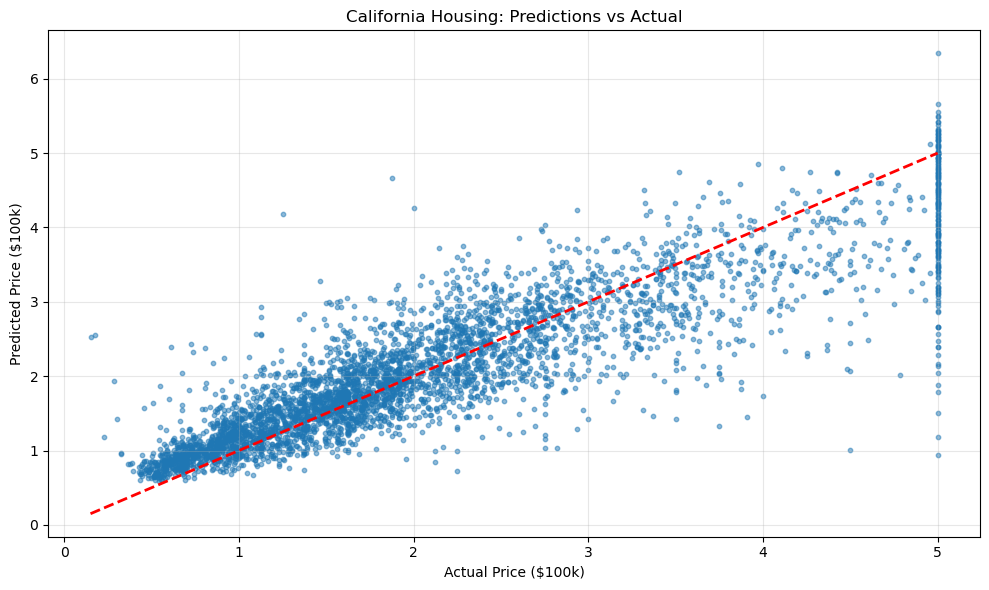

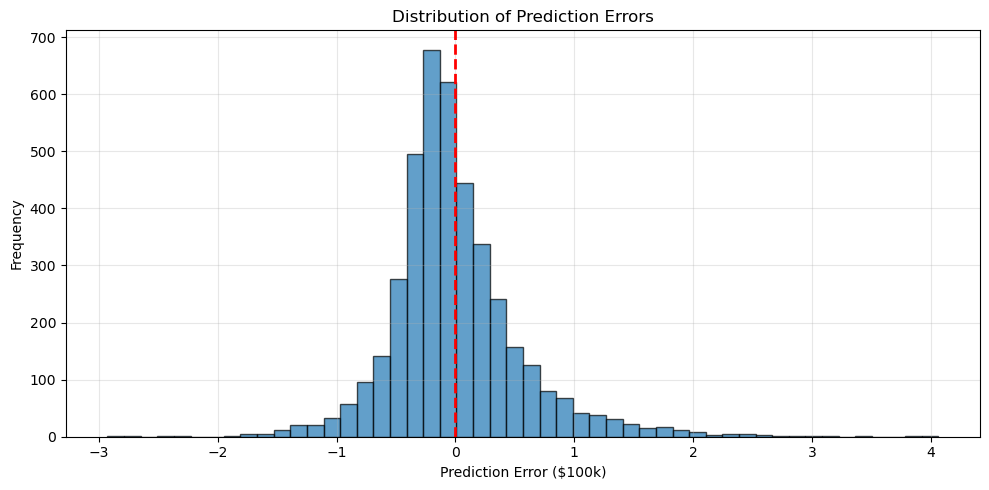

Error Statistics:
  Mean Error: $-0.00k
  Std Error:  $0.56k


In [18]:
y_pred = model_housing.predict(test_dataset, verbose=0).flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($100k)')
plt.ylabel('Predicted Price ($100k)')
plt.title('California Housing: Predictions vs Actual')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

errors = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error ($100k)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Error Statistics:")
print(f"  Mean Error: ${errors.mean():.2f}k")
print(f"  Std Error:  ${errors.std():.2f}k")

---
## 🎓 KESIMPULAN BAB 13
---

### Ringkasan Lengkap

Notebook ini mencakup **semua aspek penting** dari Bab 13: Loading & Preprocessing Data dengan TensorFlow.

#### ✅ BAGIAN I: Core Concepts

**1. tf.data API**
- ✅ Basic transformations (map, shuffle, batch, prefetch)
- ✅ Advanced features (cache, inspection)
- ✅ Performance optimization techniques

**2. TFRecord Format**
- ✅ Writing dengan tf.train.Example (format standar)
- ✅ Parsing dengan feature description
- ✅ Mixed data types (int, float, string)

**3. Keras Preprocessing Layers**
- ✅ Normalization (numerical features)
- ✅ StringLookup & CategoryEncoding (categorical)
- ✅ Embedding (high-cardinality categorical)
- ✅ TextVectorization (text data)
- ✅ Image preprocessing (Rescaling, Resizing, Augmentation)
- ✅ Discretization & Hashing (advanced cases)

#### ✅ BAGIAN II: End-to-End Pipeline

**4. Complete Real-World Example**
- ✅ California Housing dataset
- ✅ Full pipeline: Data → Preprocessing → Model → Training
- ✅ Built-in preprocessing in model
- ✅ Performance visualization
- ✅ Error analysis

### 🎯 Key Takeaways

| Komponen | Gunakan Untuk |
|----------|---------------|
| **tf.data.Dataset** | Efficient data loading & transformation pipeline |
| **TFRecord** | Large datasets, distributed training, production |
| **Normalization** | Numerical features (continuous values) |
| **StringLookup** | Categorical features (low cardinality) |
| **Hashing** | Categorical features (high cardinality) |
| **TextVectorization** | Text/NLP tasks |
| **Image Layers** | Computer vision (augmentation, rescaling) |
| **Embedding** | Categorical with learned representations |

### 🚀 Production Best Practices

1. **Always use tf.data for large datasets** - Avoid loading all data to memory
2. **Apply preprocessing inside model** - Makes model portable and GPU-accelerated
3. **Use TFRecord for distributed training** - Standard format across Google ecosystem
4. **Use cache() for small datasets** - 2-3x speedup on repeated epochs
5. **Use prefetch(AUTOTUNE)** - Overlaps data loading with training
6. **Data augmentation ONLY during training** - Set `training=True/False`